# **Graph execution error 코드 가장 마지막에 작성!**
문제 원인을 아시는 분은 답변 부탁드립니다

In [1]:
# 데이터 다운로드

!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-11-20 08:51:47--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.75.22, 52.217.17.142, 3.5.16.80, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.75.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  54.0MB/s    in 0.2s    

2024-11-20 08:51:47 (54.0 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


## 1. 데이터 조사하기

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
# 넘파이 배열로 변경

import numpy as np

# 비어있는 y data 배열
temperature = np.zeros((len(lines),))
# 비어있는 x data 배열 (Datetime 열 제외)
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]  # Datetime 빼고 1번째 열 부터
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

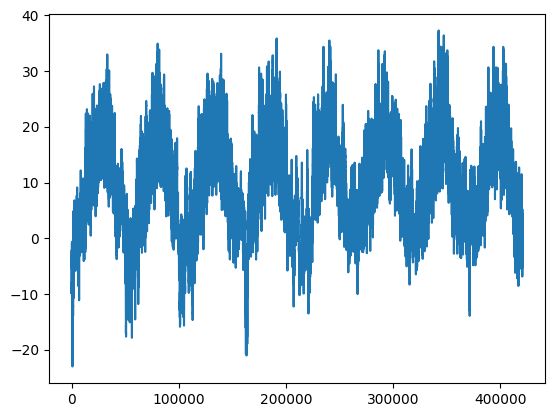

In [4]:
# 그래프 확인

from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.show()

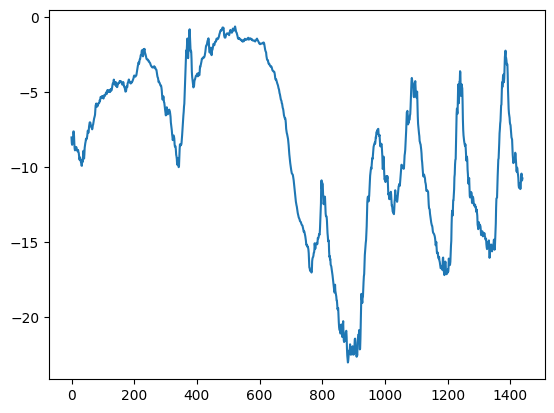

In [5]:
# 처음 10일 간의 데이터 그래프로 확인하기

plt.plot(range(1440), temperature[:1440])   # 데이터는 10분마다 1개씩 저장
plt.show()

### 시계열 데이터의 데이터 분리(training, validation, test)  

처음부터 중간까지(50%)를 training으로 사용,  
그 다음 25%를 validation, 그 다음 25%를 test로 사용

In [6]:
# 각 분할에 사용하는 샘플 수량 확인

num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### 부록 <timeseries_dataset_from_array() 이해하기>  

원본 시계열에서 추출한 윈도우(=시퀸스)를 제공  
  - 예시) data =[0 1 2 3 4 5 6)이고 sequence_length=3이면
[0 1 2],[1 2 3],[2 3 4],[3 4 5],[4 5 6] 이 출력  
함수에 targets 매개변수로 타깃 배열 전달 가능  
targets의 첫번째 원소는 data에 생성될 첫번째 시퀸스에 대한 타깃이어야 함  
그리고 시간차를 두고 data 배열과 동일해야 함  
  - 예시) data : [0 1 2 3 4 5 ...] + sequence_length=3 => targets : [3 4 5 6 7 8 ...]  


In [7]:
# timeseries_dataset_from_array() 예시

import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)                                    # 0~9 데이터 배열
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],                                     # 데이터는 0~6
    targets=int_sequence[3:],                                   # 타깃은 3~9
    sequence_length=3,
    batch_size=2,                                               # 배치 크기 2 (2개씩 계산한다는 건가)
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


### 2. 데이터 준비하기

In [8]:
# 데이터 정규화

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [9]:
# trimeseries_data_set_from_array() 매개변수 값 지정
# sampling_rate = 6 : 10분데이터 * 6 즉, 1시간마다 하나의 데이터 포인트가 샘플링됨 (10분 당 1개의 데이터 사용 -> 1시간 당 1게의 데이터 사용)
# sequence_length = 120 : 이전 120시간 즉 5일 간의 데이터 사용
# delay = sampling_rate * (sequence_length + 24 -1) : 시퀸스의 targets는 시퀸스 데이터 끝의 24시간 후 온도

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

# 데이터셋 나누기

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [10]:
# 데이터셋 크기 확인하기

def print_dataset_info(dataset):
  for samples, targets in dataset:
    print("샘플 크기:", samples.shape)
    print("타깃 크기:", targets.shape)
    print("샘플 타입:", samples.dtype)
    print("타깃 타입:", targets.dtype)
    break

print_dataset_info(train_dataset)
print_dataset_info(val_dataset)
print_dataset_info(test_dataset)

샘플 크기: (256, 120, 14)
타깃 크기: (256,)
샘플 타입: <dtype: 'float64'>
타깃 타입: <dtype: 'float64'>
샘플 크기: (256, 120, 14)
타깃 크기: (256,)
샘플 타입: <dtype: 'float64'>
타깃 타입: <dtype: 'float64'>
샘플 크기: (256, 120, 14)
타깃 크기: (256,)
샘플 타입: <dtype: 'float64'>
타깃 타입: <dtype: 'float64'>


샘플 크기 :(256, 120, 14) 의 의미  
-> 하나의 샘플은(시퀸스 데이터) 120시간의 입력데이터를 담고 있음

### 10.2.2 상식 수준의 기준점  
상식적으로 24시간 후의 온도가 지금과 동일하다고 예측해보기

In [11]:
# 평가 루프

def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]        # 정규화한 데이터 원본 데이터 규격으로 맞추기
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"검증 MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"테스트 MAE: {evaluate_naive_method(test_dataset):.2f}")

검증 MAE: 2.44
테스트 MAE: 2.62


결과 : 평균 2.5도 차이 (나쁘지 않지만 서비스화 할 수 없는 정도)

### 10.2.3 기본적인 머신 러닝 모델 시도해보기  

1D 합성곱 모델 시도해보기

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 79s 94ms/step - loss: 34.2399 - mae: 4.4487 - val_loss: 15.5956 - val_mae: 3.1327
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 76s 92ms/step - loss: 16.0057 - mae: 3.1727 - val_loss: 17.0015 - val_mae: 3.2240
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 85s 95ms/step - loss: 14.8074 - mae: 3.0525 - val_loss: 18.6731 - val_mae: 3.4072
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 100ms/step - loss: 14.0011 - mae: 2.9666 - val_loss: 16.8914 - val_mae: 3.2246
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 100ms/step - loss: 13.4010 - mae: 2.8996 - val_loss: 15.7128 - val_mae: 3.1099
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 143s 102ms/step - loss: 12.9404 - mae: 2.8452 - val_loss: 16.1140 - val_mae: 3.1427
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 142s 102ms/step - loss: 12.4661 - mae: 2.7945 - val_loss: 14.6875 - val_mae: 2.9998
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 88s 107ms/step - loss: 12.1873 - mae: 2.7616 - val_loss: 14.5716 - val_mae: 3.0020
Epoch 9/10
819/81

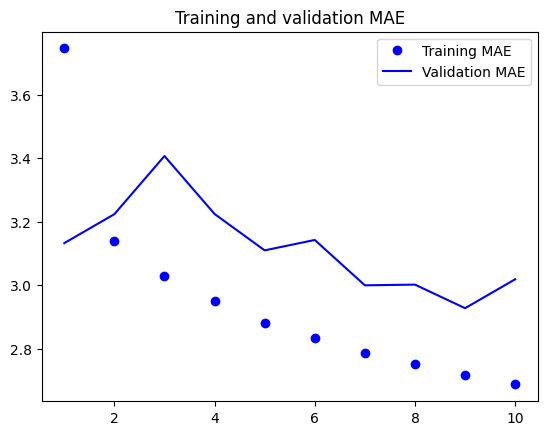

In [13]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

첫 번째 순환 신경망

In [14]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 119s 143ms/step - loss: 71.4502 - mae: 6.4858 - val_loss: 12.6210 - val_mae: 2.6960
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 108s 132ms/step - loss: 11.8534 - mae: 2.6666 - val_loss: 9.2794 - val_mae: 2.3680
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 138s 128ms/step - loss: 10.0115 - mae: 2.4679 - val_loss: 9.4346 - val_mae: 2.3829
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 105s 128ms/step - loss: 9.3658 - mae: 2.3827 - val_loss: 9.4243 - val_mae: 2.3903
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 106s 129ms/step - loss: 8.8808 - mae: 2.3215 - val_loss: 9.4430 - val_mae: 2.3942
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 103s 126ms/step - loss: 8.5518 - mae: 2.2787 - val_loss: 9.4259 - val_mae: 2.3926
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 102s 125ms/step - loss: 8.2785 - mae: 2.2411 - val_loss: 9.7015 - val_mae: 2.4250
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 143s 126ms/step - loss: 8.1339 - mae: 2.2203 - val_loss: 9.7232 - val_mae: 2.4372
Epoch 9/10
819/819 ━

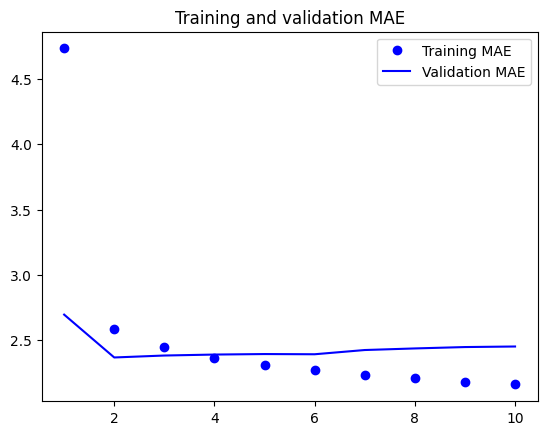

In [15]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# **코드 10-10 (p.288)**
# **InvalidArgumentError: Graph execution error**

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")



Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node functional_2_1/flatten_1/Reshape defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-16-5f2918dd2ee2>", line 12, in <cell line: 12>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 560, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py", line 54, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/numpy.py", line 4440, in reshape

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/numpy.py", line 1789, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node functional_2_1/flatten_1/Reshape}}]] [Op:__inference_one_step_on_iterator_268672]

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()
